In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # Version 1.5
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu



In [2]:
data = input_data.read_data_sets('data/fashion',one_hot=True)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [3]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=data.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=data.train.labels.shape))
# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=data.test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=data.test.labels.shape))

Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)


In [4]:
# Create dictionary of target classes
label_dict = {
0: 'T-shirt/top',
1: 'Trouser',
2: 'Pullover',
3: 'Dress',
4: 'Coat',
5: 'Sandal',
6: 'Shirt',
7: 'Sneaker',
8: 'Bag',
9: 'Ankle boot',
}

Text(0.5,1,'(Label: Ankle boot)')

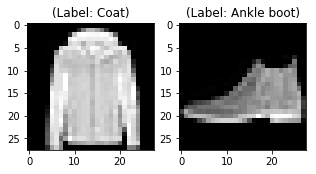

In [5]:
plt.figure(figsize=[5,5])
# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(data.train.images[0], (28,28))
curr_lbl = np.argmax(data.train.labels[0,:])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(data.test.images[0], (28,28))
curr_lbl = np.argmax(data.test.labels[0,:])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [6]:
data.train.images[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00392157,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.17254902,
       0.49803925, 0.7137255 , 0.7254902 , 0.6313726 , 0.47058827,
       0.21568629, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16470589, 0.77647066, 0.9843138 , 1.        , 0.9843138 ,
       0.97647065, 0.9686275 , 1.        , 0.98823535, 0.83921

In [7]:
np.max(data.train.images[0])

1.0

In [8]:
np.min(data.train.images[0])

0.0

In [9]:
# Reshape training and testing image
train_X = data.train.images.reshape(-1, 28, 28, 1)
test_X = data.test.images.reshape(-1,28,28,1)
train_X.shape, test_X.shape

((55000, 28, 28, 1), (10000, 28, 28, 1))

In [10]:
train_y = data.train.labels
test_y = data.test.labels
train_y.shape, test_y.shape

((55000, 10), (10000, 10))

In [11]:
training_iters = 200
learning_rate = 0.001
batch_size = 128

In [12]:
# MNIST data input (img shape: 28*28)
n_input = 28
# MNIST total classes (0-9 digits)
n_classes = 10

In [13]:
#both placeholders are of type float
x = tf.placeholder("float", [None, 28,28,1])
y = tf.placeholder("float", [None, n_classes])

In [14]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [15]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

In [16]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)


    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [18]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [19]:
#Here you check whether the index of the maximum value of the predicted image is equal
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [20]:
# Initializing the variables
init = tf.global_variables_initializer()

In [23]:
with tf.Session() as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))] 
            # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
              "{:.6f}".format(loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))
        print("Optimization Finished!")
        
        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.327325, Training Accuracy= 0.87500
Optimization Finished!
Testing Accuracy: 0.84800



KeyboardInterrupt



In [ ]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

In [ ]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy'
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()